In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pyaurorax
import cartopy.crs
import pprint

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

## Step 1: Download and read data

First up, we need to download and read the image data we're interested in, and the appropriate skymaps.

In [2]:
# download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
dt = datetime.datetime(2023, 2, 24, 7, 5)
site_uid_list = ["yknf", "gill", "rabb", "luck", "atha"]
data_list = []
for site_uid in site_uid_list:
    r = aurorax.data.ucalgary.download(dataset_name, dt, dt, site_uid=site_uid)
    data = aurorax.data.ucalgary.read(r.dataset, r.filenames)
    data_list.append(data)

In [3]:
# download and read skymaps
skymaps = []
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    skymaps.append(skymap.data[0])

pprint.pprint(skymaps)

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]


## Step 2: Build the mosaic

Next we'll create our mosaic using the ASI data, using the same way as usual. Later on, we'll overplot the satellite location information.

In [4]:
# if we're not sure which altitudes are pre-computed, we can see them inside a skymap file
#
# if you choose different altitude when preparing the skymap data, the function will take longer
# to process as it performs an interpolation between the pre-computed altitudes
print("Available pre-computed altitudes: %s" % (', '.join(["%d" % (x) for x in skymaps[0].get_precalculated_altitudes()])))

Available pre-computed altitudes: 90, 110, 150


In [5]:
# prepare the skymap data
#
# NOTE: this step is not time dependent, so it only needs to be performed once
# per set of skymaps.
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=5)

# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

In [6]:
# define the intensity scales for each site
#
# NOTE: you can define intensity scale for each site separately, all sites as a whole, or not at all
scale = {
    "yknf": [10, 90],
    "gill": [10, 90],
    "rabb": [10, 90],
    "luck": [10, 90],
    "atha": [10, 90],
}

# set timestamp to actually create mosaic frame for
mosaic_dt = datetime.datetime(2023, 2, 24, 7, 5, 0)

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, mosaic_dt, projection_obj, image_intensity_scales=scale)

# add geographic gridlines using many lines of constant lat and lon. These will go behind the image data
lat_locs = np.arange(0, 90, 10)
lon_locs = np.arange(-180, 0, 20)

# add gridlines
mosaic.add_geo_contours(constant_lats=lat_locs, constant_lons=lon_locs, linestyle="--", color="black")

## Overplot satellite location data

Now that we have our mosaic created using the ASI data, we need to retrieve some satellite location data. We will utilize the AuroraX search engine for this, searching for 'ephemeris' data.

More examples performing AuroraX ephemeris and conjunction searches can be found [here](https://data.phys.ucalgary.ca/working_with_data/index.html).

In [7]:
# Grab 30 minutes of data from Swarm A
start = datetime.datetime(2023, 2, 24, 6, 50, 0)
end = datetime.datetime(2023, 2, 24, 7, 20, 0)
programs = ["swarm"]
platforms = ["swarma"]
instrument_types = ["footprint"]

# Perform search
s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)

# Organize data into a list of dicts
ephemeris_data = [e.__dict__ for e in s.data]

# Create lists of lats and lons for all timestamps
lats = []
lons = []
for i in range(len(ephemeris_data)):
    lats.append(ephemeris_data[i]["location_geo"].lat)
    lons.append(ephemeris_data[i]["location_geo"].lon)

# Add the footprint of Swarm A over 30 minutes
mosaic.add_geo_contours(lats=lats, lons=lons, linestyle='-', color="red", bring_to_front=True)

[2025-01-21 17:34:41.815992] Search object created
[2025-01-21 17:34:41.882366] Request submitted
[2025-01-21 17:34:41.882438] Request ID: 775061fc-32af-4c4c-b80d-b19fb338546e
[2025-01-21 17:34:41.882464] Request details available at: https://api.aurorax.space/api/v1/ephemeris/requests/775061fc-32af-4c4c-b80d-b19fb338546e
[2025-01-21 17:34:41.882487] Waiting for data ...
[2025-01-21 17:34:43.320784] Checking for data ...
[2025-01-21 17:34:43.745953] Data is now available
[2025-01-21 17:34:43.746156] Retrieving data ...
[2025-01-21 17:34:43.855130] Retrieved 177.5 kB of data containing 31 records


In [8]:
# Get exact location of satellite at time of mosaic
start = datetime.datetime(2023, 2, 24, 7, 5, 0)
end = datetime.datetime(2023, 2, 24, 7, 5, 0)
programs = ["swarm"]
platforms = ["swarma"]
instrument_types = ["footprint"]

# Perform search
s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)

# Organize data into a list of dicts
ephemeris_data = [e.__dict__ for e in s.data]

# Create lists of lats and lons for all timestamps
lats = []
lons = []
for i in range(len(ephemeris_data)):
    lats.append(ephemeris_data[i]["location_geo"].lat)
    lons.append(ephemeris_data[i]["location_geo"].lon)

# Add the location of SWARM A at the exact time of this mosaic
mosaic.add_geo_contours(lats=lats, lons=lons, color="red", bring_to_front=True, marker='o')

[2025-01-21 17:34:43.892954] Search object created
[2025-01-21 17:34:43.918563] Request submitted
[2025-01-21 17:34:43.918630] Request ID: ea75a494-520f-4d46-be09-d00b06b2cfa4
[2025-01-21 17:34:43.918657] Request details available at: https://api.aurorax.space/api/v1/ephemeris/requests/ea75a494-520f-4d46-be09-d00b06b2cfa4
[2025-01-21 17:34:43.918680] Waiting for data ...
[2025-01-21 17:34:45.339256] Checking for data ...
[2025-01-21 17:34:45.764532] Data is now available
[2025-01-21 17:34:45.764722] Retrieving data ...
[2025-01-21 17:34:45.834748] Retrieved 5.8 kB of data containing 1 records


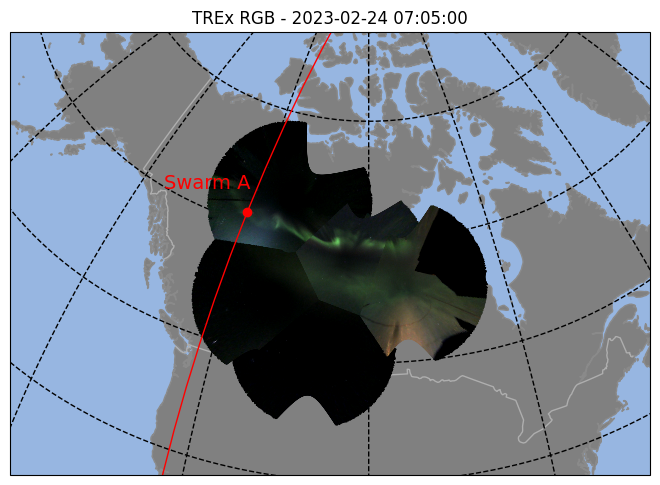

In [9]:
# Obtain mosaic plot so we can do some custom things to it
map_extent = [-140, -70, 35, 75]
fig, geo_axes = mosaic.plot(map_extent, title="TREx RGB - %s" % (mosaic_dt.strftime("%Y-%m-%d %H:%M:%S")), returnfig=True)

# Plot the mosaic and add some of our own text
plt.figure(fig.number)
geo_axes.text(lons[0] - 15, lats[0] - 1, "Swarm A", color="red", transform=cartopy.crs.PlateCarree(), fontsize=14)  # Add label for satellite
plt.show()